In [1]:
import tushare as ts
import pandas as pd
import numpy as np
#数据选取2015到2018三年的数据
xshg_df=ts.get_hist_data('sh')
xshg_df.sort_index(ascending=True,inplace=True)
#提取原列名，昨日数据的列名
c0=xshg_df.columns.tolist()
#将
def adany(s):
    def ad0(r):
        rr=str(r)
        ss=str(s)
        a=rr+ss
        return a

    return ad0
#重新命名前天和大前天的数据
f1=adany(1)
c1=list(map(f1,c0))

f2=adany(2)
c2=list(map(f2,c0))

#提取预测值
p=xshg_df.p_change
ay=p.to_frame()
ay=ay.shift(-3)
ay.columns=['p']
ay.reset_index(drop=True,inplace=True)

#将3个表合并
a=xshg_df.shift(-2)
a.reset_index(drop=True,inplace=True)

a2=xshg_df
a2.reset_index(drop=True,inplace=True)
a2.columns=c2

a1=xshg_df.shift(-1)
a1.reset_index(drop=True,inplace=True)
a1.columns=c1



train=pd.concat([a,a1,a2,ay],axis=1)
train.dropna(axis=0,inplace=True)


# #计算均线
# for i in np.arange(50,train.shape[0]):
#     train.loc[i,'ma5']=np.mean(train.loc[i-5:i,'close2'])
#     train.loc[i,'ma10']=np.mean(train.loc[i-10:i,'close2'])
#     train.loc[i,'ma20']=np.mean(train.loc[i-20:i,'close2'])


#计算均线斜率
#首先用二次函数拟合
from scipy.optimize import curve_fit
def lin(x,a,b,c):
    r=a*x*x+b*x+c
    return r
#计算各条均线的斜率
for i in np.arange(30,train.shape[0]):
    coef5,_=curve_fit(lin,np.arange(30),train.loc[i-29:i,'ma5'])
    train.loc[i,'ma5i']=coef5[0]*58+coef5[1]
    
    coef10,_=curve_fit(lin,np.arange(30),train.loc[i-29:i,'ma10'])
    train.loc[i,'ma10i']=coef10[0]*58+coef10[1]
    
    coef20,_=curve_fit(lin,np.arange(30),train.loc[i-29:i,'ma20'])
    train.loc[i,'ma20i']=coef20[0]*58+coef20[1]

#分出训练集tr，训练标签trl,测试集ts,测试标签tsl
dftr=train.loc[31:430,:].drop(['p'],axis=1)
trl=train.loc[31:430,'p'].values
trl=trl.reshape(-1,1)                                 #为了方便喂给tensorflow
dfts=train.loc[431:,:].drop(['p'],axis=1)
tsl=train.loc[431:,'p'].values
tsl=tsl.reshape(-1,1)
df=pd.concat([dftr,dfts],axis=0)

#将数据归一化
from sklearn import preprocessing
mas=preprocessing.MaxAbsScaler()
ta=mas.fit_transform(df)
tr=ta[:400,:]
ts=ta[400:,:]




In [2]:
# #定义将涨跌幅分类的函数
# def p2l(a):
#     import math
#     m=-4
#     for i in np.arange(a.shape[0]):
#         a[i]=max(m,math.ceil(a[i]-0.5))+4   
#     return a
# trl=p2l(trl)
# tsl=p2l(tsl)


In [3]:
%run gplearn_features.ipynb

In [4]:
tr,ts=t2gp(tr,trl,ts,4,25)

D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.99 0.04263005228072014       30 0.24030206522144196 0.1297796881145415      8.75s
   1    12.73 0.08526958255366421       31 0.2784611146558217 0.21598887774919595      5.96s
   2     13.2 0.12879665694417877       12 0.3521234087558496 0.19164050313710088      3.04s
   3    26.41 0.17690693540610944       35 0.34779510710852424 0.13502387833800394      0.00s


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
#clfrf=RandomForestClassifier(n_estimators=25)
clfrf=RandomForestRegressor(n_estimators=25)
clfrf.fit(tr,trl)
ptr=clfrf.predict(tr)
ptr=ptr.reshape(-1,1)
btr=abs(ptr-trl)
pbtr=np.mean(btr)

lrf= ptr==trl
arf= lrf.astype(int)
rfrate=arf.mean()

import matplotlib.pyplot as plt 
plt.figure(figsize=(40,20))
plt.plot(trl,color='red')
plt.plot(ptr,color='green')
plt.show()


pts=clfrf.predict(ts)
pts=pts.reshape(-1,1)
bts=abs(pts-tsl)
pbts=np.mean(bts)

lrf1= pts==tsl
arf1= lrf1.astype(int)
rfrate1=arf1.mean()


plt.figure(figsize=(40,20))
plt.plot(tsl,color='red')
plt.plot(pts,color='blue')
plt.show()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


<Figure size 4000x2000 with 1 Axes>

<Figure size 4000x2000 with 1 Axes>

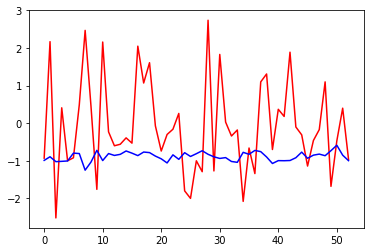

In [7]:
plt.plot(tsl,color='red')
plt.plot(pts,color='blue')
plt.show()

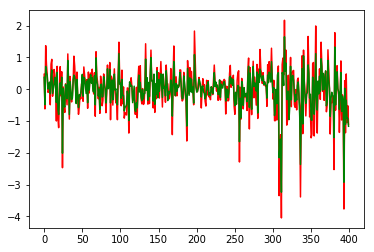

In [8]:
plt.plot(trl,color='red')
plt.plot(ptr,color='green')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

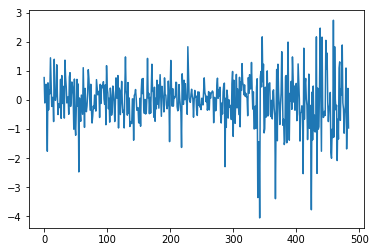

In [9]:
plt.plot(train.p)